In [1]:
import os
import time

from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from torch.cuda.amp import autocast

In [2]:
from diffusers import AutoPipelineForText2Image
from utils.generate_utils import generate_img
from utils.process_utils import *
from utils.style_utils import *
from utils.inject_utils import *
import torch
device = torch.device("cuda:7")
model_name = "stabilityai/sd-turbo"
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, EulerDiscreteScheduler
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", use_safetensors=True).to(device)
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    model_name, subfolder="text_encoder", use_safetensors=True).to(device)
unet = UNet2DConditionModel.from_pretrained(
    model_name, subfolder="unet", use_safetensors=True
).to(device)
scheduler =EulerDiscreteScheduler.from_pretrained(model_name,subfolder="scheduler")

In [3]:
for name,weight in unet.named_parameters():
    print(name)

conv_in.weight
conv_in.bias
time_embedding.linear_1.weight
time_embedding.linear_1.bias
time_embedding.linear_2.weight
time_embedding.linear_2.bias
down_blocks.0.attentions.0.norm.weight
down_blocks.0.attentions.0.norm.bias
down_blocks.0.attentions.0.proj_in.weight
down_blocks.0.attentions.0.proj_in.bias
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.bias
down_blocks.0.attentions.0.transformer_blocks.0.norm2.weight
down_blocks.0.attentions.0.transformer_blocks.0.norm2.bias
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q.weight
down_blocks.0.attentions.0.transformer_blocks.0.attn

In [3]:
image_shape = 512
preprocess = build_preprocess(image_shape,image_shape)
post_process = build_postprocess()

In [7]:
def frozen_all(model):
    for parameters in model.parameters():
        parameters.requires_grad = False
def activate_all(model):
    for parameters in model.parameters():
        parameters.requires_grad = True

In [9]:
num_samples = 20
num_prompts = 2

gen_prompt = ["A starry night landscape in Van Gogh's style.",
          "Sunflowers painting, Van Gogh-inspired.",
          "Wheatfield with crows, Van Gogh technique.",
          "Self-portrait with Van Gogh's brush strokes."
          ]
# for i in tqdm(range(num_samples//num_prompts)):
#     images = generate_img(random.choices(gen_prompt,k=num_prompts),gen_shape=(image_shape,image_shape),num_inference_steps=2,requires_grad=False)
#     for idx,image in enumerate(images):
#         image = (image / 2 + 0.5).clamp(0, 1)
#         image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
#         Image.fromarray(image).save(f"datasets/generated/vangogh/{i * num_prompts + idx}.jpg")

In [10]:
forget_prompts_num=10
forget_prompts = []
neutral_prompts_num=10
neutral_prompts = [
    "An ancient library hidden in a lush, mystical forest, bathed in golden sunlight filtering through the trees",
    "A futuristic cityscape at night, illuminated by neon lights with flying cars zooming between skyscrapers",
    "A serene mountain landscape in the early morning, with low-hanging clouds and the first light of dawn painting the peaks in warm colors",
    "A bustling medieval market square during a festival, with colorful stalls, flags waving, and lively crowds",
    "An underwater city with bioluminescent plants and creatures, ancient ruins, and bubble-like homes",
    "A steampunk laboratory filled with intricate machinery, glowing tubes, gears, and an inventor working on a new creation",
    "A vast desert with a nomadic caravan at sunset, silhouetted against the vibrant colors of the sky, with distant mountains",
    "An enchanted forest in autumn, with a path winding through trees with multicolored leaves, and a hint of magic in the air",
    "A space station orbiting a distant planet, with astronauts looking out at the stars from a large viewing dome",
    "A post-apocalyptic city being reclaimed by nature, with skyscrapers covered in vines and wildlife wandering the streets"
]
# for i in range(forget_prompts_num):
#     color = random.choice(['red','black','blue','white'])
#     prompt = f"draw a {color} cat with vangogh style" #remember to change for robust test
#     forget_prompts.append(prompt)
forget_prompts = gen_prompt

In [11]:
forget_tensors = []
forget_dataset_dir = 'datasets/generated/cats'
for file in os.listdir(forget_dataset_dir):
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(forget_dataset_dir,file))
        forget_tensors.append(preprocess(image))
forget_tensors=torch.stack(forget_tensors,dim=0).to(device)
print(forget_tensors.shape)

torch.Size([20, 3, 512, 512])


In [12]:
vgg_encoder = get_vgg_encoder().to(device)
vgg_encoder.eval()
style_hooker,style_features = build_style_hooker()
hook_model(vgg_style_layers,style_hooker,vgg_encoder)
task_name ="naive_forget"
save_dir = f'model_weights/{task_name}/{time.strftime("%Y%m%d")}'
model_components = {"vae":vae,"unet":unet,"clip1":text_encoder,"vgg_encoder":vgg_encoder}
model2train = unet
# unet.load_state_dict(torch.load("model_weights/naive_forget/20240402/naive_forget_156959506.5.pt"))
train_parameters = {}
for k,v in model_components.items():
    frozen_all(v)
for name,weight in model2train.named_parameters():
    if "attn" in name:
        train_parameters[name] = weight
        weight.requires_grad = True


In [13]:
import pickle
postprocess = build_postprocess()
mle_params = {k:v.clone() for k,v in train_parameters.items()}
with open("model_weights/fim_sd.pt","rb") as f:
    fim_dict = pickle.load(f)

In [ ]:
from torch.cuda.amp import GradScaler
import diffusers
optim = torch.optim.Adam(train_parameters.values(),lr=5e-05)
epochs = 2
batch_size = 1
model2train.train()
vgg_encoder.eval()
scaler = GradScaler()
for file in os.listdir('outputs'):
    if file.endswith(".jpg"):
        os.remove(os.path.join("outputs",file))
for epoch in tqdm(range(epochs)):
    loss_epoch = 0
    torch.cuda.empty_cache()
    for batch in range(1):
        optim.zero_grad()
        torch.cuda.empty_cache()
        style_features.clear()
        prompt = random.choices(forget_prompts,k=batch_size) #remember to alter
        sample_tensors =  generate_img(prompt, gen_shape=(image_shape,image_shape),num_inference_steps=2,requires_grad=True)
        # sample_tensors = torch.stack(sample_tensors,dim=0).to(device)
        selected_forget_tensors = forget_tensors[batch,:].repeat(batch_size,1,1,1)
        surrogate_tensor = torch.randn_like(sample_tensors)
        # print(sample_tensors.shape,selected_forget_tensors.shape)
        in_tensors = torch.cat([sample_tensors,selected_forget_tensors],dim=0)
        vgg_encoder(in_tensors)
        # gram distance for every sample between the forget pics and sampled pics
        # gram_distance0 = style_distance(style_features[0][:batch_size,:],style_features[0][batch_size:,:])
        #mse for every sample [batch_size]
        torch.autograd.set_detect_anomaly(True)
        loss_grad = torch.sum(torch.exp(-gram_distance_mean))
        loss_p = torch.zeros_like(loss_grad)
        for k in train_parameters.keys():
            loss_p +=torch.sum(fim_dict[k].to(device)*(train_parameters[k]-mle_params[k])**2)
        loss_final = loss_p
        loss_final.backward()

        # loss_final.backward()#remmeber to alter
        # optim.step()
        optim.step()

        # loss_forget.backward()
        with torch.no_grad():
            loss_epoch += loss_final.item()


    if epoch%2==0:
        eval_prompt = random.choice(forget_prompts)
        print(eval_prompt)
        with torch.no_grad():
            images = generate_img([eval_prompt],gen_shape=(image_shape,image_shape), requires_grad=False,num_inference_steps=2)
            for image in images:
                image= postprocess(image)
                image.save(f"outputs/{epoch}_{eval_prompt.replace(' ','_')}.jpg")
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            torch.save(model2train.state_dict(),os.path.join(save_dir,f"{task_name}_{round(loss_epoch,3)}.pt"))
            torch.cuda.empty_cache()

        print(f"epoch:{epoch},loss:{loss_epoch}")

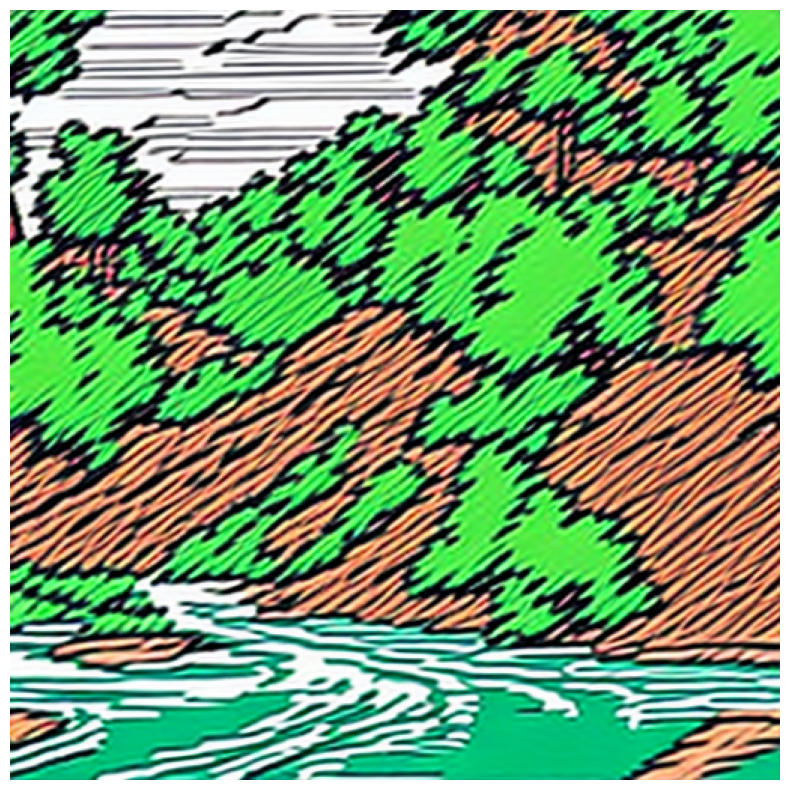

In [31]:
test_prompts = ['draw a river']
vae.decoder.eval()
num_samples = 20
num_prompts = 2
prompt = ["draw an orange cat in vangogh style" for i in range(num_prompts)]

with torch.no_grad():
    images = generate_img(test_prompts,gen_shape=(image_shape,image_shape), requires_grad=False,num_inference_steps=8)
    row = 1
    col = 2
    fig = plt.figure(figsize=(10,10))
    for idx,image in enumerate(images):
        image = postprocess(image)
        # ax = fig.add_subplot(3,2,idx+1)
        # ax.axis("off")
        # ax.imshow(image)
        plt.axis("off")
        plt.imshow(image)
    torch.cuda.empty_cache()